#Medical insurance prediction

This notebook focuses on analyzing medical insurance data and predicting insurance charges based on demographic and lifestyle factors. The goal is to explore the dataset, identify patterns affecting costs, and build a predictive model.
Dataset source: [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance)

## Dataset analysis

In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'insurance' dataset.
Path to dataset files: /kaggle/input/insurance
['insurance.csv']


Checking data integrity (presence of None or NaN values).

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

url = path + '/insurance.csv'
df = pd.read_csv(url)

target_column = "charges"
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [ ]:
print(df.shape)
df.head(6)     # bmi - body mass index

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


Creating a categorical variable from the 'children' field by grouping values of 4 and above into the category "4+".

In [ ]:
df['children'] = df['children'].apply(lambda x: '4+' if x >= 4 else str(x))

children
0     574
1     324
2     240
3     157
4+     43
Name: count, dtype: int64


Analyzing each feature

Numerical features: ['age', 'bmi', 'charges']
Categorical features: ['sex', 'region', 'smoker', 'children']


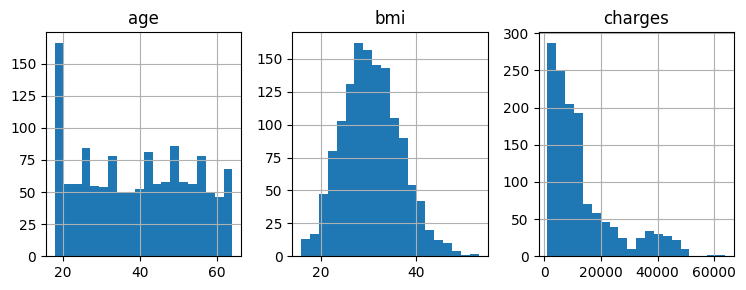

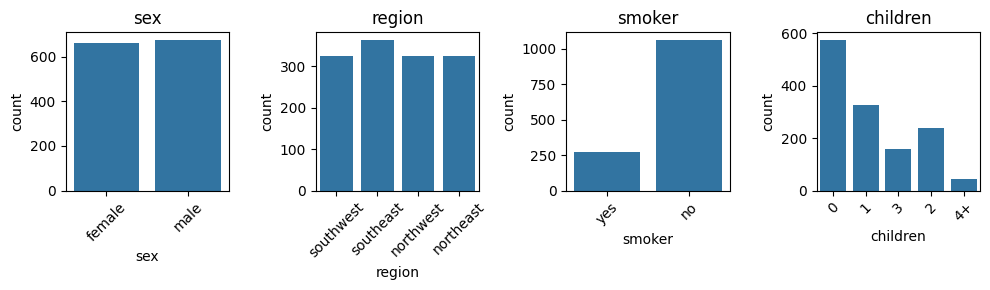

In [ ]:
cat_cols = ['sex', 'region', 'smoker', 'children']
num_cols = [col for col in df.columns if col not in cat_cols]

print("Numerical features:", list(num_cols))
print("Categorical features:", list(cat_cols))

n = len(num_cols)
cols = 4
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(10, 3*rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    df[col].hist(bins=20, ax=axes[i])
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


n = len(cat_cols)
cols = 4
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(10, 3*rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
display(df[num_cols].describe().T)


,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


Implementing one-hot encoding for categorical features

In [ ]:
def one_hot(df, columns):
    df_encoded = df.copy()

    for col in columns:
        categories = df_encoded[col].unique()
        for cat in categories[1:]:
            new_col = f"{col}_{cat}"
            df_encoded[new_col] = (df_encoded[col] == cat).astype(int)
        df_encoded.drop(columns=[col], inplace=True)
    return df_encoded

df_num = one_hot(df, ['region', 'sex', 'smoker', 'children'])
df_num.head()

,age,bmi,charges,region_southeast,region_northwest,region_northeast,sex_male,smoker_no,children_1,children_3,children_2,children_4+
0,19,27.900,16884.92400,0,0,0,0,0,0,0,0,0
1,18,33.770,1725.55230,1,0,0,1,1,1,0,0,0
2,28,33.000,4449.46200,1,0,0,1,1,0,1,0,0
3,33,22.705,21984.47061,0,1,0,1,1,0,0,0,0
4,32,28.880,3866.85520,0,1,0,1,1,0,0,0,0


Creating correlation matrix

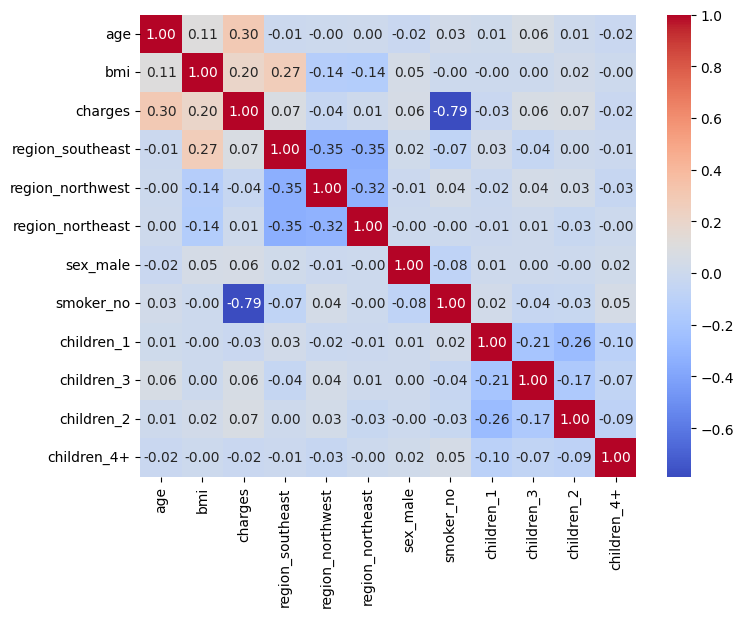

In [ ]:
corr_matrix = df_num.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [ ]:
X = df_num.drop('charges', axis=1)
y = df_num['charges']

#Polynomial regression

In [ ]:
def standard_scale(X):
    X = np.array(X, dtype=float)
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    eps = 1e-10
    X_scaled = (X - mean) / (std + eps)
    return X_scaled, mean, std

def inverse_transform(y_scaled, mean, std):
    return y_scaled * std + mean

In [ ]:
class Regression:
    def __init__(self, alpha=1.0, lr=0.001, max_iter=10000, tol=1e-6):
        self.alpha = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.coef = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape

        self.coef = np.zeros((n_features,1))

        for it in range(self.max_iter):
            y_pred = X @ self.coef
            error = y_pred - y
            grad = np.zeros_like(self.coef)

            grad = (X.T @ error) / n_samples
            grad[1:] += self.alpha * np.sign(self.coef[1:])
            self.coef -= self.lr * grad

            if np.linalg.norm(grad) < self.tol:
                break

    def predict(self, X):
        return X @ self.coef


In [ ]:
def mean_squared_error_manual(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error_manual(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse_manual(y_true, y_pred):
    return np.sqrt(mean_squared_error_manual(y_true, y_pred))

def r2_score_manual(y_true, y_pred):
    diff = np.sum((y_true - y_pred) ** 2)
    var = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - diff / var

def regression_metrics_manual(y_true, y_pred):
    return {
        'R2': r2_score_manual(y_true, y_pred),
        'MSE': mean_squared_error_manual(y_true, y_pred),
        'RMSE': rmse_manual(y_true, y_pred),
        'MAE': mean_absolute_error_manual(y_true, y_pred)
    }


In [ ]:
def cv_split(n_samples, n_splits=5,random_state=None):
    indices = np.arange(n_samples)

    rg = np.random.default_rng(seed=random_state)
    rg.shuffle(indices)

    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1

    current = 0
    for fold_size in fold_sizes:
        test_idx = indices[current:current+fold_size]
        train_idx = np.concatenate((indices[:current], indices[current+fold_size:]))
        yield train_idx, test_idx
        current += fold_size


We use polynomial regression with degree 2 and L1 (Lasso) regularization.

In [ ]:
X_scaled = standard_scale(X)[0]
y = np.array(y, dtype=float).reshape(-1,1)
y_scaled, y_mean_orig, y_std_orig = standard_scale(y)

X_poly = X_scaled.copy()
n_features = X_scaled.shape[1]
for i in range(n_features):
    for j in range(i, n_features):
        X_poly = np.hstack((X_poly, (X_scaled[:, i] * X_scaled[:, j]).reshape(-1,1)))
X_poly = np.hstack((np.ones((X_poly.shape[0],1)), X_poly))

alpha = 0.01
metrics_train_all, metrics_test_all = [], []

for train_idx, test_idx in cv_split(X_poly.shape[0], n_splits=5, random_state=42):
    X_train, X_test = X_poly[train_idx], X_poly[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

    model = Regression(alpha=alpha)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_pred_orig = inverse_transform(y_train_pred, y_mean_orig, y_std_orig)
    y_test_pred_orig  = inverse_transform(y_test_pred, y_mean_orig, y_std_orig)
    y_train_orig = inverse_transform(y_train, y_mean_orig, y_std_orig)
    y_test_orig  = inverse_transform(y_test, y_mean_orig, y_std_orig)

    metrics_train_all.append(regression_metrics_manual(y_train_orig, y_train_pred_orig))
    metrics_test_all.append(regression_metrics_manual(y_test_orig, y_test_pred_orig))

avg_metrics_train = {k: round(float(np.mean([m[k] for m in metrics_train_all])), 3) for k in metrics_train_all[0]}
avg_metrics_test  = {k: round(float(np.mean([m[k] for m in metrics_test_all])), 3) for k in metrics_test_all[0]}

print("Train metrics:", avg_metrics_train)
print("Test metrics:", avg_metrics_test)


Train metrics: {'R2': 0.848, 'MSE': 22330034.796, 'RMSE': 4722.731, 'MAE': 2950.733}
Test metrics: {'R2': 0.84, 'MSE': 23632770.415, 'RMSE': 4820.123, 'MAE': 3032.222}


Here we can see deference between quantity of features after one-hot encoding and after creating polynomial features.

In [ ]:
print(X_scaled.shape)
print(X_poly.shape)

(1338, 11)
(1338, 78)
